[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5984
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 34
[LightGBM] [Info] Start training from score 27414.075000
Regression Evaluation: {'rmse': 3963533.59159883, 'mae': 1564.1594753461502, 'r2': 0.9431984051009997}
[LightGBM] [Info] Number of positive: 3171, number of negative: 29
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5984
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990938 -> initscore=4.694506
[LightGBM] [Info] Start training from score 4.694506
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

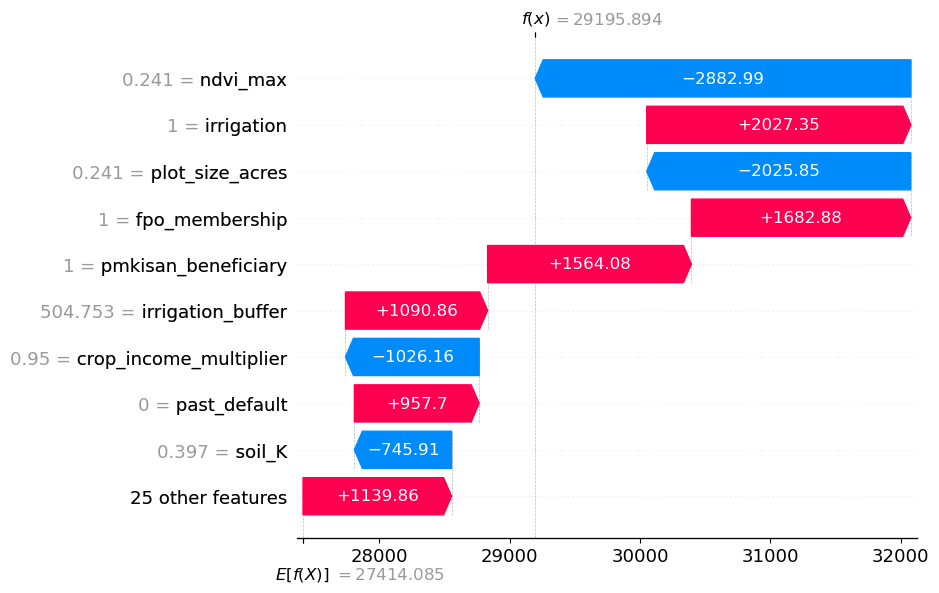

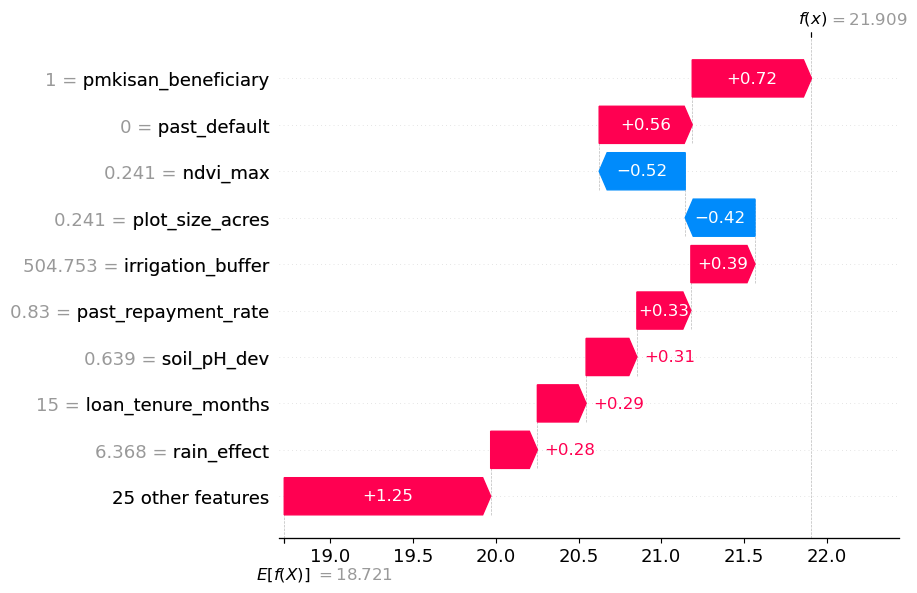

SHAP plots generated successfully!
  ✓ Feature importance bar plots (regression & classification)
  ✓ Beeswarm plots showing positive/negative feature impacts
  ✓ Waterfall plots for individual sample explanations
Generating feature importance plots...
Feature importance plots generated successfully!

Artifacts saved and bundled.

Generated SHAP visualizations:
📊 Bar plots (Feature Importance):
  - shap_reg_bar.png (Credit Limit)
  - shap_cls_bar.png (Loan Approval)
🐝 Beeswarm plots (Positive/Negative Impact):
  - shap_reg_beeswarm.png (Credit Limit)
  - shap_cls_beeswarm.png (Loan Approval)
💧 Waterfall plots (Individual Explanations):
  - shap_reg_waterfall.png (Credit Limit Sample)
  - shap_cls_waterfall.png (Loan Approval Sample)
⚡ Feature Importance plots:
  - feature_importance_reg.png
  - feature_importance_cls.png
📦 All artifacts bundled in: terracred_artifacts_bundle.zip


In [15]:
import os, json, zipfile, datetime, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# ML imports with graceful degradation
use_lgb = True
use_shap = True
try:
    import lightgbm as lgb
except Exception:
    use_lgb = False
try:
    import shap
except Exception:
    use_shap = False

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
import joblib
import matplotlib.pyplot as plt

# -------------------------
# OUTPUTS
# -------------------------
OUT_DIR = "terracred_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

RNG_SEED = 42
np.random.seed(RNG_SEED)

df = pd.read_csv(r'https://raw.githubusercontent.com/ayanatherate/TerraCred-AI/refs/heads/main/data/terracred_full_data.csv')
crop_types = ["paddy", "wheat", "maize", "sugarcane", "cotton", "pulses"]
df["crop_type"] = np.random.choice(crop_types, size=n, p=[0.26,0.24,0.16,0.1,0.14,0.1])

# -------------------------------------------
# 2) ENGINEERED FEATURES
# -------------------------------------------
df["log_price_volatility"] = np.log1p(df["price_volatility"])
df["log_distance_to_market"] = np.log1p(df["distance_to_market_km"])
df["rain_effect"] = df["rain_7d"] / (1.0 + df["dry_spell"])
df["water_stress_index"] = (df["dry_spell"] / (df["rain_7d"] + 1.0)).clip(0, 5)
df["soil_pH_dev"] = np.abs(df["soil_pH"] - 6.5)
df["market_advantage"] = df["market_access_score"] - df["log_distance_to_market"]
df["growth_outlook"] = (df["ndvi_trend_30d"] * 5_000 + df["rain_forecast_14d"]).clip(-2000, 10000)
df["digital_enablement"] = 0.6 * df["mobile_penetration_score"] + 0.4 * df["market_access_score"]
df["irrigation_buffer"] = df["irrigation"] * (df["rain_forecast_14d"] * 0.15 + 500)
crop_base_map = {"paddy":1.0,"wheat":1.0,"maize":0.95,"sugarcane":1.2,"cotton":1.05,"pulses":0.9}
df["crop_income_multiplier"] = df["crop_type"].map(crop_base_map)

# -------------------------------------------
# 3) TARGET: CREDIT LIMIT (regression)
# -------------------------------------------
base_capacity = (
    df["ndvi_max"]*23000 + df["soil_N"]*14000 + df["soil_K"]*9000 + df["irrigation"]*6000
) * df["crop_income_multiplier"]
soil_penalty = - df["soil_pH_dev"] * 2200
seasonal = (df["rain_effect"]*12.0 + df["ndvi_trend_30d"]*4800 + df["rain_forecast_14d"]*3.2)
market = ((2200/(1.0+df["price_volatility"])) + df["market_advantage"]*340 + (df["avg_crop_price_last_3m"]/9.5))
social = (df["pmkisan_beneficiary"]*3200 + df["fpo_membership"]*2600 + df["fertilizer_subsidy"]*1600 +
          df["crop_insurance"]*1200 + df["digital_enablement"]*110)
size_effect = (np.minimum(df["plot_size_acres"],3.0)*4200) + np.maximum(df["plot_size_acres"]-3.0,0.0)*2000
risk_penalty = (- df["past_default"]*16000 - (1.0-df["past_repayment_rate"])*9500 -
                df["yield_variability_3y"]*12000 - df["log_distance_to_market"]*480)
tenure_penalty = - (np.maximum(df["loan_tenure_months"]-12,0))*120
epsilon = np.random.normal(0, 1400, size=n)

df["credit_limit"] = (
    base_capacity + soil_penalty + seasonal + market + social +
    size_effect + risk_penalty + tenure_penalty + epsilon
).clip(0,100000).round(0)

# -------------------------------------------
# 3B) TARGET: LOAN APPROVAL (binary)
# -------------------------------------------
approval_score = (
    0.00006 * df["credit_limit"] +
    2.5 * df["past_repayment_rate"] -
    2.0 * df["past_default"] -
    3.0 * df["yield_variability_3y"] +
    0.08 * df["market_access_score"] +
    np.random.normal(0, 0.5, size=n)
)
prob = 1 / (1 + np.exp(-approval_score))
df["loan_approval"] = (prob > 0.5).astype(int)

# -------------------------------------------
# 4) MODEL FEATURES
# -------------------------------------------
feature_cols = [
    "ndvi_max","ndvi_trend_30d","rain_7d","rain_forecast_14d","dry_spell",
    "soil_N","soil_K","soil_pH","price_volatility","avg_crop_price_last_3m",
    "pmkisan_beneficiary","plot_size_acres","irrigation","past_default",
    "past_repayment_rate","yield_variability_3y","loan_tenure_months",
    "market_access_score","mobile_penetration_score","fpo_membership",
    "fertilizer_subsidy","crop_insurance","distance_to_market_km",
    "crop_type","log_price_volatility","log_distance_to_market","rain_effect",
    "water_stress_index","soil_pH_dev","market_advantage","growth_outlook",
    "digital_enablement","irrigation_buffer","crop_income_multiplier"
]
df["crop_type"] = df["crop_type"].astype("category")
X = df[feature_cols]

# -------------------------------------------
# 5) REGRESSION MODEL
# -------------------------------------------
y_reg = df["credit_limit"].values
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=RNG_SEED)

if use_lgb:
    model_reg = lgb.LGBMRegressor(n_estimators=600, learning_rate=0.05,
                                  subsample=0.85, colsample_bytree=0.85,
                                  min_child_samples=40, objective="regression",
                                  random_state=RNG_SEED)
    model_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)],
                  eval_metric="rmse", categorical_feature=["crop_type"])
else:
    X_train = pd.get_dummies(X_train, columns=["crop_type"], drop_first=True)
    X_test = pd.get_dummies(X_test, columns=["crop_type"], drop_first=True)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    model_reg = RandomForestRegressor(n_estimators=600, min_samples_leaf=2, random_state=RNG_SEED)
    model_reg.fit(X_train, y_train)

preds = model_reg.predict(X_test)
metrics_reg = {"rmse": float(mean_squared_error(y_test, preds)),
               "mae": float(mean_absolute_error(y_test, preds)),
               "r2": float(r2_score(y_test, preds))}
json.dump(metrics_reg, open(os.path.join(OUT_DIR,"metrics_regression.json"),"w"), indent=2)
print("Regression Evaluation:", metrics_reg)

# -------------------------------------------
# 6) CLASSIFICATION MODEL
# -------------------------------------------
y_cls = df["loan_approval"].values
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.2, random_state=RNG_SEED)

if use_lgb:
    model_cls = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05,
                                   subsample=0.85, colsample_bytree=0.85,
                                   min_child_samples=40, objective="binary",
                                   random_state=RNG_SEED)
    model_cls.fit(X_train_cls, y_train_cls, eval_set=[(X_test_cls, y_test_cls)],
                  eval_metric="auc", categorical_feature=["crop_type"])
else:
    X_train_cls = pd.get_dummies(X_train_cls, columns=["crop_type"], drop_first=True)
    X_test_cls = pd.get_dummies(X_test_cls, columns=["crop_type"], drop_first=True)
    X_test_cls = X_test_cls.reindex(columns=X_train_cls.columns, fill_value=0)
    model_cls = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, random_state=RNG_SEED)
    model_cls.fit(X_train_cls, y_train_cls)

preds_proba = model_cls.predict_proba(X_test_cls)[:,1]
preds_cls = (preds_proba >= 0.5).astype(int)
metrics_cls = {"accuracy": float(accuracy_score(y_test_cls, preds_cls)),
               "roc_auc": float(roc_auc_score(y_test_cls, preds_proba))}
json.dump(metrics_cls, open(os.path.join(OUT_DIR,"metrics_classification.json"),"w"), indent=2)
print("Classification Evaluation:", metrics_cls)

# -------------------------------------------
# 7) SHAP EXPLANATIONS (Enhanced)
# -------------------------------------------
if use_shap and use_lgb:
    print("Generating SHAP explanations...")
    
    # Regression SHAP
    explainer_reg = shap.TreeExplainer(model_reg)
    shap_values_reg = explainer_reg.shap_values(X_test)
    
    # Summary bar plot for regression (Feature Importance)
    shap.summary_plot(shap_values_reg, X_test, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance - Credit Limit Regression")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_reg_bar.png"), dpi=160, bbox_inches='tight')
    plt.close()
    
    # Beeswarm plot for regression (Positive/Negative Impact)
    shap.summary_plot(shap_values_reg, X_test, show=False)
    plt.title("SHAP Summary Plot - Credit Limit Regression (Feature Impact)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_reg_beeswarm.png"), dpi=160, bbox_inches='tight')
    plt.close()
    
    # Create Explanation object for waterfall plot (regression)
    explanation_reg = shap.Explanation(values=shap_values_reg[0], 
                                      base_values=explainer_reg.expected_value, 
                                      data=X_test.iloc[0].values,
                                      feature_names=X_test.columns.tolist())
    
    # Waterfall plot for first test sample (regression)
    fig, ax = plt.subplots(figsize=(10, 8))
    shap.waterfall_plot(explanation_reg)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_reg_waterfall.png"), dpi=160, bbox_inches='tight')
    plt.close()
    
    # Classification SHAP
    explainer_cls = shap.TreeExplainer(model_cls)
    shap_values_cls = explainer_cls.shap_values(X_test_cls)
    
    # Summary bar plot for classification
    if isinstance(shap_values_cls, list):
        # Binary classification returns list of arrays
        shap_values_cls_positive = shap_values_cls[1]
        expected_value_cls = explainer_cls.expected_value[1]
    else:
        # Single array case
        shap_values_cls_positive = shap_values_cls
        expected_value_cls = explainer_cls.expected_value
    
    # Summary bar plot for classification (Feature Importance)
    shap.summary_plot(shap_values_cls_positive, X_test_cls, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance - Loan Approval Classification")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_cls_bar.png"), dpi=160, bbox_inches='tight')
    plt.close()
    
    # Beeswarm plot for classification (Positive/Negative Impact)
    shap.summary_plot(shap_values_cls_positive, X_test_cls, show=False)
    plt.title("SHAP Summary Plot - Loan Approval Classification (Feature Impact)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_cls_beeswarm.png"), dpi=160, bbox_inches='tight')
    plt.close()
    
    # Create Explanation object for waterfall plot (classification)
    explanation_cls = shap.Explanation(values=shap_values_cls_positive[0], 
                                      base_values=expected_value_cls, 
                                      data=X_test_cls.iloc[0].values,
                                      feature_names=X_test_cls.columns.tolist())
    
    # Waterfall plot for first test sample (classification)
    fig, ax = plt.subplots(figsize=(10, 8))
    shap.waterfall_plot(explanation_cls)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_cls_waterfall.png"), dpi=160, bbox_inches='tight')
    plt.close()
    
    print("SHAP plots generated successfully!")
    print("  ✓ Feature importance bar plots (regression & classification)")
    print("  ✓ Beeswarm plots showing positive/negative feature impacts")
    print("  ✓ Waterfall plots for individual sample explanations")

# -------------------------------------------
# 8) FEATURE IMPORTANCE PLOTS
# -------------------------------------------
if use_lgb:
    print("Generating feature importance plots...")
    
    # Regression feature importance
    feature_imp_reg = model_reg.feature_importances_
    feature_names = X_train.columns if hasattr(X_train, 'columns') else feature_cols
    
    # Sort features by importance
    indices = np.argsort(feature_imp_reg)[::-1]
    top_n = min(20, len(feature_imp_reg))  # Show top 20 features
    
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importance - Credit Limit Regression")
    plt.barh(range(top_n), feature_imp_reg[indices[:top_n]])
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]])
    plt.xlabel("Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "feature_importance_reg.png"), dpi=160, bbox_inches='tight')
    plt.close()
    
    # Classification feature importance
    feature_imp_cls = model_cls.feature_importances_
    feature_names_cls = X_train_cls.columns if hasattr(X_train_cls, 'columns') else feature_cols
    
    # Sort features by importance
    indices_cls = np.argsort(feature_imp_cls)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importance - Loan Approval Classification")
    plt.barh(range(top_n), feature_imp_cls[indices_cls[:top_n]])
    plt.yticks(range(top_n), [feature_names_cls[i] for i in indices_cls[:top_n]])
    plt.xlabel("Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "feature_importance_cls.png"), dpi=160, bbox_inches='tight')
    plt.close()
    
    print("Feature importance plots generated successfully!")

# -------------------------------------------
# 9) SAVE MODELS + DATA
# -------------------------------------------
joblib.dump(model_reg, os.path.join(OUT_DIR, "terracred_regressor.joblib"))
joblib.dump(model_cls, os.path.join(OUT_DIR, "terracred_classifier.joblib"))
df.to_csv(os.path.join(OUT_DIR,"terracred_full_synthetic.csv"), index=False)

# Bundle
with zipfile.ZipFile("terracred_artifacts_bundle.zip", 'w', zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(OUT_DIR):
        for file in files:
            zf.write(os.path.join(root, file), arcname=os.path.join("terracred_artifacts", file))

print("\nArtifacts saved and bundled.")
print(f"\nGenerated SHAP visualizations:")
print("📊 Bar plots (Feature Importance):")
print("  - shap_reg_bar.png (Credit Limit)")
print("  - shap_cls_bar.png (Loan Approval)")
print("🐝 Beeswarm plots (Positive/Negative Impact):")
print("  - shap_reg_beeswarm.png (Credit Limit)")
print("  - shap_cls_beeswarm.png (Loan Approval)")
print("💧 Waterfall plots (Individual Explanations):")
print("  - shap_reg_waterfall.png (Credit Limit Sample)")
print("  - shap_cls_waterfall.png (Loan Approval Sample)")
print("⚡ Feature Importance plots:")
print("  - feature_importance_reg.png")
print("  - feature_importance_cls.png")
print("📦 All artifacts bundled in: terracred_artifacts_bundle.zip")